<a href="https://colab.research.google.com/github/plaban1981/DEEP-LEARNING-/blob/master/Cell_images_for_Detecting_Malaria_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"7021605f0dadd19e198a07f397efa623"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:21<00:00, 34.9MB/s]
100% 675M/675M [00:21<00:00, 33.2MB/s]


In [ ]:
! unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [ ]:

!mkdir '/content/cell_images/train/'
!mkdir '/content/cell_images/val/'

In [19]:
!mkdir '/content/cell_images/train/Parasitized/'
!mkdir '/content/cell_images/train/Uninfected/'
!mkdir '/content/cell_images/val/Parasitized/'
!mkdir '/content/cell_images/val/Uninfected/'

In [14]:
import os
image_names = []
labels = []
for image in  os.listdir('/content/cell_images/cell_images/Parasitized/'):
  image_names.append(image)
  labels.append(1)

In [15]:
for image in  os.listdir('/content/cell_images/cell_images/Uninfected/'):
  image_names.append(image)
  labels.append(0)

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_names,labels,test_size=0.20,random_state=42,stratify=labels)

In [21]:
len(X_train)

22048

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


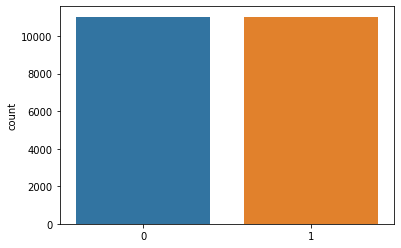

In [18]:
import seaborn as sns
sns.countplot(y_train)

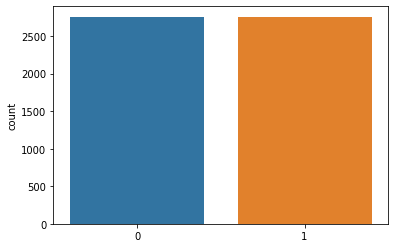

In [22]:
sns.countplot(y_test)

In [20]:
import shutil
img_path1 = '/content/cell_images/cell_images/Parasitized/'
img_path2 = '/content/cell_images/cell_images/Uninfected/'
dest1 = '/content/cell_images/train/Parasitized/'
dest2 = '/content/cell_images/train/Uninfected/'
for img,lbl in zip(X_train,y_train):
  if lbl ==1:
    shutil.copy(img_path1+img,dest1)
  else:
    shutil.copy(img_path2+img,dest2)

In [23]:
img_path1 = '/content/cell_images/cell_images/Parasitized/'
img_path2 = '/content/cell_images/cell_images/Uninfected/'
dest3 = '/content/cell_images/val/Parasitized/'
dest4 = '/content/cell_images/val/Uninfected/'
for img,lbl in zip(X_test,y_test):
  if lbl ==1:
    shutil.copy(img_path1+img,dest3)
  else:
    shutil.copy(img_path2+img,dest4)

In [24]:
data_dir = '/content/cell_images/'



In [25]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
device

device(type='cuda', index=0)

# Visualize a few images

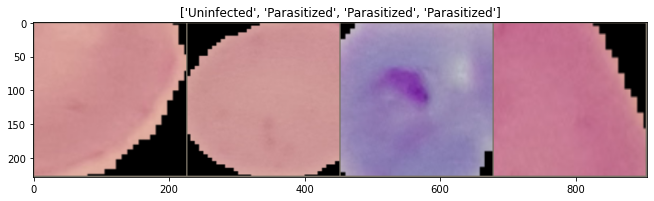

In [31]:
plt.figure(figsize=(11,8))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [35]:
model_ft = models.vgg16(pretrained=True)

In [38]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
model_ft.classifier[0]

Linear(in_features=25088, out_features=4096, bias=True)

In [40]:
model_ft.classifier[0].in_features

25088

In [41]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[0].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [42]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7900 Acc: 0.5108
val Loss: 0.6902 Acc: 0.5493

Epoch 1/24
----------
train Loss: 0.5038 Acc: 0.7370
val Loss: 0.1937 Acc: 0.9282

Epoch 2/24
----------
train Loss: 0.3541 Acc: 0.8503
val Loss: 0.1901 Acc: 0.9425

Epoch 3/24
----------
train Loss: 0.3374 Acc: 0.8588
val Loss: 0.1702 Acc: 0.9436

Epoch 4/24
----------
train Loss: 0.3302 Acc: 0.8625
val Loss: 0.1622 Acc: 0.9458

Epoch 5/24
----------
train Loss: 0.3181 Acc: 0.8663
val Loss: 0.1723 Acc: 0.9367

Epoch 6/24
----------
train Loss: 0.3189 Acc: 0.8651
val Loss: 0.1487 Acc: 0.9496

Epoch 7/24
----------
train Loss: 0.2911 Acc: 0.8773
val Loss: 0.1362 Acc: 0.9530

Epoch 8/24
----------
train Loss: 0.2805 Acc: 0.8834
val Loss: 0.1275 Acc: 0.9543

Epoch 9/24
----------
train Loss: 0.2730 Acc: 0.8844
val Loss: 0.1246 Acc: 0.9539

Epoch 10/24
----------
train Loss: 0.2683 Acc: 0.8887
val Loss: 0.1268 Acc: 0.9508

Epoch 11/24
----------
train Loss: 0.2689 Acc: 0.8860
val Loss: 0.1216 Acc: 0.9554

Ep

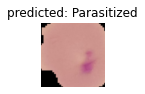

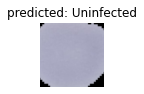

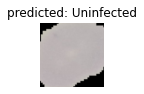

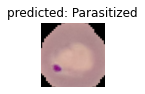

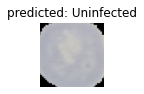

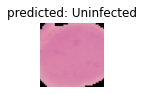

In [44]:
visualize_model(model_ft)
plt.ioff()
plt.show()

In [79]:
weights_fname = 'malaria-vgg16.pth'
torch.save(model_ft.state_dict(), weights_fname)